In [20]:
%load_ext autoreload

import os
import sys
import pandas as pd
import numpy as np
from pandas.api.types import is_numeric_dtype, is_object_dtype

import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as metrics

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

root_dir = os.path.abspath('..')
sys.path.append(os.path.join(root_dir, 'src/'))

import feature_preprocess
import eda_functions
import baseline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
DATA_FOLDER = os.path.join(root_dir, 'data/')
TRAIN_FILE = 'train.csv'
TEST_FILE = 'test.csv'
SEGMENTS_FILE = 'Segments.xlsx'
CITIES_FILE = 'data_cities.csv'
RANDOM_STATE = 27

FRAC = 0.05

pd.set_option('display.max_columns', None)

# Загрузка данных

In [3]:
segments = pd.read_excel(os.path.join(DATA_FOLDER, SEGMENTS_FILE))
display(segments)

,Номер сегмента,Возраст,Пол,Интересы
0,1,"25-34,35-41",Ж,-
1,2,"25-34,35-42",М,Пиво
2,3,"25-34,35-43",Ж,Дети
3,4,"18-24,25-34,35-44","М, Ж",Животные
4,5,"18-24,25-34,35-45","М, Ж",-


In [4]:
train_raw = pd.read_csv(os.path.join(DATA_FOLDER, TRAIN_FILE))
display(train_raw.head())
print(train_raw.shape)

,Segment,gamecategory,subgamecategory,bundle,created,shift,oblast,city,os,osv
0,4,Games,Racing,com.MadOut.BIG,2021-07-05 18:07:40,MSK+6,Забайкальский Край,Чита,android,10.0
1,4,NaN,NaN,com.easybrain.solitaire.klondike.free,2021-07-10 10:38:42,MSK+2,Оренбургская область,Оренбург,Android,10.0.0
2,5,Games,Arcade,com.orbitalknight.ridiculousfreekick,2021-08-04 13:34:29,MSK,Санкт-Петербург,Санкт-Петербург,android,9.0
3,5,NaN,NaN,tcouchgind.scooterextreme.scooter,2021-08-06 07:35:27,MSK+2,Свердловская область,Екатеринбург,android,9
4,4,NaN,NaN,com.FidgetTrading3D.game,2021-08-02 20:43:59,MSK,Московская область,Звенигород,android,6.0.1


(44854516, 10)


In [5]:
_, train_raw_frac = train_test_split(train_raw, test_size=FRAC, random_state=RANDOM_STATE, stratify=train_raw['Segment'])

In [6]:
del train_raw

In [7]:
test_raw = pd.read_csv(os.path.join(DATA_FOLDER, TEST_FILE))
display(test_raw.head())
print(test_raw.shape)

,gamecategory,subgamecategory,bundle,created,shift,oblast,city,os,osv
0,Applications,Shopping,com.allgoritm.youla,2021-09-19 17:31:33,MSK+2,Свердловская область,Екатеринбург,android,10.0
1,NaN,NaN,com.ChocochocoStd.RapBattle,2021-08-03 17:13:17,MSK+2,Ямало-Ненецкий АО,Новый Уренгой,android,10.0
2,NaN,NaN,1387897651,2021-09-17 15:54:00,MSK,Москва,Москва,ios,14.4.0
3,NaN,NaN,com.cooking.family.diary.fever.food.city.craze...,2021-07-05 23:34:59,MSK,Краснодарский край,Краснодар,android,9.0.0
4,Applications,Health & Fitness,com.pedometer.stepcounter.tracker,2021-07-08 15:15:21,MSK,Татарстан,Набережные Челны,android,10.0


(11213629, 9)


In [8]:
def prepare_X_y(data, target, prefix='Segment', drop_duplicates=False):
    data = data.copy()

    if drop_duplicates:
        data.drop_duplicates(inplace=True)
    
    targets_df = pd.get_dummies(data[target], prefix=prefix)

    X = data.drop(columns=target)

    return X, targets_df

In [9]:
def train_model(pars, X_train, y_train, X_val, y_val, eval_metric):

    model = lightgbm.LGBMClassifier(**pars)
    model.fit(X_train, y_train, eval_metric=eval_metric, eval_set=(X_val, y_val))

    return model

def validate_model(model, X_train, y_train, X_val, y_val):

    print('model')
    print('Train roc auc', metrics.roc_auc_score(y_train, model.predict_proba(X_train).T[1]))
    print('Validation roc auc', metrics.roc_auc_score(y_val, model.predict_proba(X_val).T[1]))

    print(metrics.classification_report(y_val, model.predict(X_val)))

    eda_functions.plot_confusion_matrix(y_val, model.predict(X_val))

In [10]:
def check_roc_auc(y_true, y_pred_proba):
    for true, pred_proba in zip(y_true, y_pred_proba):
        print(true.name)
        print(metrics.roc_auc_score(true, pred_proba))

# Подготовка обучающего датасета

In [11]:
train_raw_cities_ftrs = \
    feature_preprocess.make_features_from_cities(train_raw_frac, os.path.join(DATA_FOLDER, CITIES_FILE))

train_raw_time_ftrs = \
feature_preprocess.make_features_from_time(
    train_raw_cities_ftrs,
    dt_target='loc',
    datetime_col_msk='created',
    shift_col = 'shift',
    fill_shift_na=False,
    shift_filler='MSK',
    dt_format = '%Y-%m-%d %H:%M:%S'
    )

tags_cols = [
    'weekday',
    'is_weekend',
    'is_academic_year',
    'is_early_morning',
    'is_morning',
    'is_day',
    'is_evening',
    'is_late_evening',
    'is_night'
]

train_raw_time_ftrs = feature_preprocess.get_tags_from_time_features(
    train_raw_time_ftrs, 
    tags_cols=tags_cols, 
    tags_dict=None)

In [12]:
del train_raw_frac

In [13]:
train_raw_cities_time_ftrs = train_raw_cities_ftrs.join(train_raw_time_ftrs)
train_raw_cities_time_ftrs.drop(columns=['created', 'shift'], inplace=True)

In [14]:
del train_raw_cities_ftrs
del train_raw_time_ftrs

In [15]:
train_raw_cities_time_ftrs['subgamecategory'], mode_sub = \
    feature_preprocess.impute_column(train_raw_cities_time_ftrs, 'subgamecategory')


In [16]:
train_raw_cities_time_ftrs['gamecategory'], mode_game = \
    feature_preprocess.impute_column(train_raw_cities_time_ftrs, 'gamecategory')

In [28]:
# bundles_preprocessed_train = \
#     feature_preprocess.bundle_preprocess(
#         train_raw_cities_time_ftrs,
#         quantity_words_flag=True,
#         bundles_bow_flag=False,
#         bundles_parts_bow_flag=True,
#         bow_make_binary=True)

(31931,)
bundles_parts_bow_flag ready
quantity_words_flag ready


In [17]:
# train_raw_all_ftrs = train_raw_cities_time_ftrs.merge(bundles_preprocessed_train, on='bundle', how='left')
train_raw_all_ftrs = train_raw_cities_time_ftrs.copy()

In [18]:
del train_raw_cities_time_ftrs
# del bundles_preprocessed_train

In [19]:
display(train_raw_all_ftrs.head())

,Segment,gamecategory,subgamecategory,bundle,oblast,city,os,osv,population,children,type,latitude_dd,longitude_dd,timezone,loc_weekday_tag,loc_is_weekend_tag,loc_is_academic_year_tag,loc_time_of_day_tag
0,5,Games,Strategy,com.redantz.game.stickwars2,архангельская область,северодвинск,android,7.1.2,182291.0,36999.0,г,64.562500,39.818056,0,среда,рабочий_день,каникулы,утро
1,3,Shopping,None,1016489154,москва,москва,ios,14.7.1,12380664.0,2025064.0,г,55.753889,37.620278,0,суббота,выходной,каникулы,день
2,3,Games,Role Playing,com.nexters.herowars,москва,москва,android,11.0.0,12380664.0,2025064.0,г,55.753889,37.620278,0,понедельник,рабочий_день,каникулы,вечер
3,4,Games,Simulation,com.yourstoryinteractive.sails.pirate.adventure,самарская область,самара,android,10.0,1156608.0,200473.0,г,53.195556,50.101667,1,понедельник,рабочий_день,каникулы,день
4,4,Games,Arcade,com.iposedon.bricksbreakerballs,татарстан,казань,Android,10,NaN,NaN,NaN,NaN,NaN,0,понедельник,рабочий_день,каникулы,утро


In [32]:
train,  valid_test = train_test_split(train_raw_all_ftrs, test_size=0.3, random_state=RANDOM_STATE, stratify=train_raw_all_ftrs['Segment'])
valid, test = train_test_split(valid_test, test_size=0.5, random_state=RANDOM_STATE, stratify=valid_test['Segment'])

In [33]:
del valid_test

In [34]:
X_train, y_train = prepare_X_y(train, 'Segment', prefix='Segment', drop_duplicates=True)
X_valid, y_valid = prepare_X_y(valid, 'Segment', prefix='Segment', drop_duplicates=False)
X_test, y_test = prepare_X_y(test, 'Segment', prefix='Segment', drop_duplicates=False)

train
5    601563
3    496547
4    389973
2     49568
1     32257
Name: Segment, dtype: int64


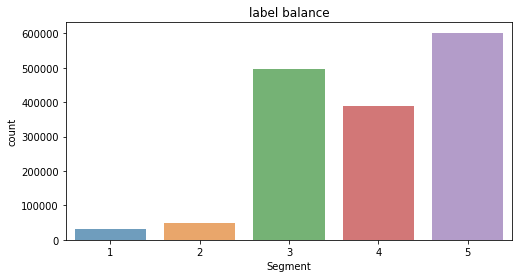

validation
5    128906
3    106403
4     83565
2     10622
1      6913
Name: Segment, dtype: int64


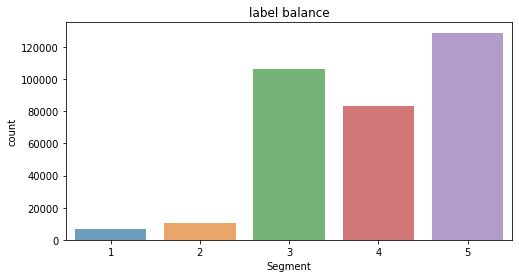

test
5    128906
3    106403
4     83566
2     10622
1      6912
Name: Segment, dtype: int64


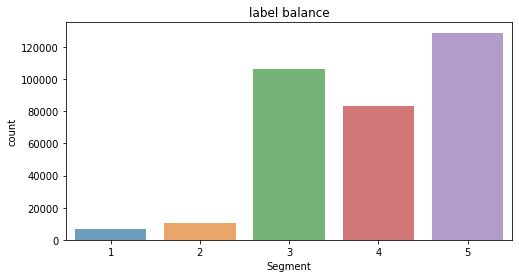

In [35]:
for d, name in zip([train, valid, test], ['train', 'validation', 'test']):
    print(name)
    eda_functions.show_label_balance(d, label='Segment')

In [36]:
del train
del valid
del test

# Обучение моделей

In [37]:
target_names = [col for col in y_train.columns]
print(target_names)

['Segment_1', 'Segment_2', 'Segment_3', 'Segment_4', 'Segment_5']


In [38]:
pars = {}
models = {}
eval_metric='auc'
TRAIN_FRAC = 1

In [ ]:
category_cols = ['gamecategory', 'subgamecategory', 'bundle' 'oblast', 'city_x' 'os_x', 'osv', 'type', 'timezone', ]

In [42]:
X_train

,gamecategory,subgamecategory,bundle,oblast,city_x,os_x,osv,population,children,type,latitude_dd,longitude_dd,timezone,loc_minute,loc_hour,loc_day,loc_month,loc_weekday,loc_is_weekend,loc_days_to_weekend,loc_is_academic_year,loc_is_first_september,loc_is_week_before_first_september,loc_is_early_morning,loc_is_morning,loc_is_day,loc_is_evening,loc_is_late_evening,loc_is_night,ab,abi,absolutist,action,addon,addons,advance,adventure,adventures,aha,aim,air,airplane,airport,alarm,all,alpha,amanotes,among,amongus,an,and,android,angry,animal,animals,anime,anmp,anti,antistress,antivirus,aos,app,applock,apps,appscraft,appstrend,aquarium,arcade,arena,army,art,asmolgam,asmr,assassin,attack,atv,audio,auto,autoclicker,avatar,avatars,baby,backgammon,background,baldi,baldisbasic,ball,balls,ballz,bank,battle,battleground,beat,beauty,best,bestringtonesapps,bg,bianf,bible,big,bigcake,bike,billiards,bingo,bitmango,black,blackout,blast,block,blockpuzzle,blocks,blue,board,body,book,boost,booster,bounce,box,boxing,boy,boyfriend,br,brain,brawl,breaker,breyman,brick,bricks,browser,bts,bubble,bubbles,bubbleshooter,build,builder,building,buildingcraftinggames,bus,button,by,calculator,call,callrecorder,camera,candy,car,card,cardgame,cardgames,cards,cargames,cargo,cars,cartoon,cartooncat,cash,casino,casual,cat,cats,cg,cgs,challenge,changer,chase,chat,checkers,chef,chess,chicken,city_y,clash,classic,clean,cleaner,cleverapps,clicker,client,clock,clown,club,cn,co,coach,cocoplay,codigames,coin,collage,collagemaker,collection,color,colorbynumber,coloring,coloringbook,com,combat,commando,company,connect,construction,control,cookapps,cooking,cool,cop,cosmicgamesfactory,counter,craft,crafting,craftingbuilding,craftingtv,craftsman,crash,craze,crazy,crazylabs,creative,creepy,crime,crimecity,critical,cross,crossword,crush,cs,cscmobi,cube,cut,cute,daily,dance,dancing,dark,dash,day,de,dead,decor,deer,defaultcompany,defense,delivery,demolition,derby,design,destruction,dev,dg,diamond,dice,dino,dinosaur,diy,dk,dmitsoft,doctor,document,dodamgames,dog,doll,dominigames,dominoes,door,dop,download,downloader,dragon,dragons,draw,drawing,dream,dressup,drift,drink,drive,driver,driving,dsg,durak,duty,ea,earth,easy,easybrain,eco,editor,effect,eg,eightfloor,emergency,emoji,empire,en,engine,english,enjen,enp,epic,equalizer,es,escape,eu,euro,evil,evolution,excavator,exploration,extreme,extremedevelopers,f2p,fa,face,factory,fake,fakecall,falcon,fall,family,fantasy,farm,farming,fashion,fast,fatlion,fever,ff,fgs,fgz,fidget,fight,fighter,fighting,file,filemanager,find,fire,firerabbit,fish,fishing,fitness,fivebn,flash,flashlight,flight,flying,fm,fmf,fnf,fnfcharactertest,followers,food,football,for,force,forecast,forest,formcpe,formula,fps,free,free2play,freecell,freegame,freegames,freemium,frenzy,friday,fridaynight,fridaynightfunkin,friends,fruit,fun,fungames,funkin,funny,furniture,g,g5e,galaxy,gallery,game,gamehouse,gameinsight,gameloft,games,games1st,games2win,gamestart,gameswing,gangster,garden,gb,gem,gems,generagames,genius,gf,gg,ghost,girl,girls,gl,glitter,global,gma,go,god,gold,google,googleplay,gp,gpp,gps,grand,granny,grannygrandpamods,gs,gsoftteam,gt,gta,guide,gun,guns,gym,hacker,hair,happy,hd,head,heart,heavy,helicopter,hello,hero,herocraft,heroes,hexa,hfg,hg,hgamesart,hgamesartworks,hidden,hiddenobjects,higgs,high,highway,hit,home,homedesign,hop,hoptiles,horror,horse,hospital,hotel,house,huawei,hunt,hunter,hunting,hyper,hyperbeard,ice,id,idle,ig,igg,ikeyboard,image,images,impossible,impossibletracks,imposter,impostor,in,inc,incredible,indiegame,infinity,info,instagram,io,iron,is,island,it,jam,jeep,jelly,jet,jewel,jewels,jigsaw,journey,jp,jump,jumping,jungle,jurassic,kamagames,kawaii,ketchapp,keyboard,kidga,kids,killer,king,kingdom,kitchen,kiwigo,klondike,kodular,kongregate,kr,kwalee,language,last,launcher,league,learn,legend,legends,life,light,lihuhu,like,likes,limo,lion,lite,little,live,livewallpaper,lock,lockscreen,lockwoodpublishing,lokicraft,love,lucky,ludo,luxury,machine,m

In [39]:


pars['Segment_1'] = {
    'verbose': -1,
    'num_leaves': 31,
    'n_estimators':  300,
    'learning_rate': 0.1,
    'metric': 'f1',
    'class_weight': 'balanced',
    'early_stopping_round': 10,
}

pars['Segment_2'] = {
    'verbose': -1,
    'num_leaves': 31,
    'n_estimators':  300,
    'learning_rate': 0.1,
    'metric': 'f1',
    'class_weight': 'balanced',
    'early_stopping_round': 10,
}

pars['Segment_3'] = {
    'verbose': -1,
    'num_leaves': 31,
    'n_estimators':  300,
    'learning_rate': 0.1,
    'metric': 'f1',
    'class_weight': 'balanced',
    'early_stopping_round': 10,
}

pars['Segment_4'] = {
    'verbose': -1,
    'num_leaves': 31,
    'n_estimators':  300,
    'learning_rate': 0.1,
    'metric': 'f1',
    'class_weight': 'balanced',
    'early_stopping_round': 10,
}

pars['Segment_5'] = {
    'verbose': -1,
    'num_leaves': 31,
    'n_estimators':  300,
    'learning_rate': 0.1,
    'metric': 'f1',
    'class_weight': 'balanced',
    'early_stopping_round': 10,
}

In [40]:
for targ in target_names
    models[targ] = train_model(
        pars,
        X_train,
        y_train[targ], 
        X_valid,
        y_valid[targ],
        eval_metric)

ValueError: DataFrame.dtypes for data must be int, float or bool.
Did not expect the data types in the following fields: gamecategory, subgamecategory, bundle, oblast, city_x, os_x, osv, type, timezone

In [ ]:
for key in target_names:
    X_train_sample = X_train.sample(frac=TRAIN_FRAC, random_state=RANDOM_STATE)
    y_train_sample = y_train[key][X_train_sample.index]

    X_valid_sample = X_valid.sample(frac=TRAIN_FRAC, random_state=RANDOM_STATE)
    y_valid_sample = y_valid[key][X_valid_sample.index]

    validate_model(models[key], X_train_sample, y_train_sample, X_valid_sample, y_valid_sample)